# Data and data split

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
from ISLP import load_data

data = load_data('Wage')
data

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154
...,...,...,...,...,...,...,...,...,...,...,...
2995,2008,44,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,2. >=Very Good,1. Yes,5.041393,154.685293
2996,2007,30,2. Married,1. White,2. HS Grad,2. Middle Atlantic,1. Industrial,2. >=Very Good,2. No,4.602060,99.689464
2997,2005,27,2. Married,2. Black,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.193125,66.229408
2998,2005,27,1. Never Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,2. >=Very Good,1. Yes,4.477121,87.981033


b## Data split

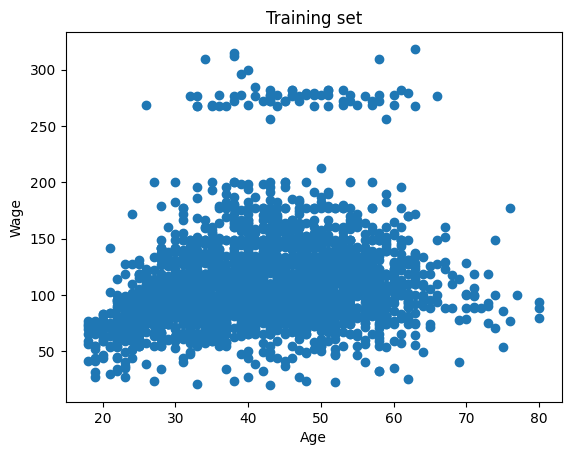

In [81]:
from sklearn.model_selection import train_test_split


X, y = data[['age']], data[['wage']]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

plt.scatter(x_train, y_train)
plt.xlabel('Age')
plt.ylabel('Wage')
plt.title("Training set")
plt.show()

# Metric and plot function

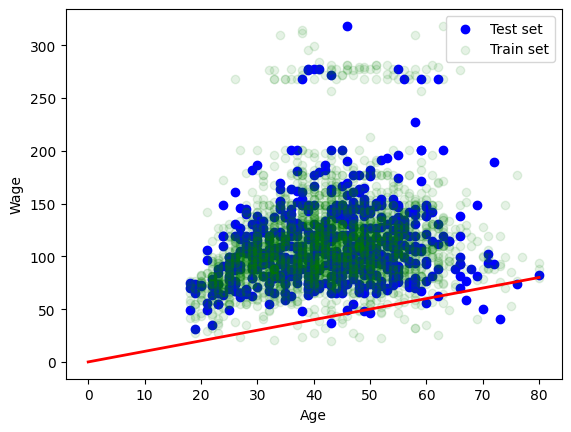

,MSE,RMSE,R2
0,0.0,0.0,1.0


In [82]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

def metric(y_hat, y_true):
    score = pd.DataFrame({
        'MSE': [mean_squared_error(y_true, y_hat)],
        'RMSE':[np.sqrt(mean_squared_error(y_true, y_hat))],
        'R2': [r2_score(y_true, y_hat)],
    })


    return score


def plot(coefs):
    global y_train, y_test

    polynomial = np.poly1d(coefs)
    x = np.linspace(0, 80, 400)
    y = polynomial(x)

    plt.plot(x, y, color='red', linewidth=2)
    plt.scatter(x_test, y_test, color='blue', label='Test set')
    plt.scatter(x_train, y_train, color='green', label='Train set', alpha=0.1)
    plt.xlabel('Age')
    plt.ylabel('Wage')
    plt.legend()
    plt.show()



plot([1,0])
metric(y_train, y_train)

# Polynomial Regression


In [83]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression


pipeline = Pipeline([('poly', PolynomialFeatures(degree=2)), ('regressor', LinearRegression())])

pipeline

Pipeline(steps=[('poly', PolynomialFeatures()),
                ('regressor', LinearRegression())])

## Optimal degree of polynomial  - MSE Minimalization

In [84]:
import optuna
from sklearn.model_selection import cross_val_score


def object_poly(trial):
    global x_train, x_test
    degree = trial.suggest_int('poly__degree', 1, 20)
    pipeline = Pipeline([('poly', PolynomialFeatures(degree=degree)), ('regressor', LinearRegression(fit_intercept=False))])
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(pipeline, x_train, y_train, cv=cv, scoring= 'neg_mean_squared_error').mean()

    return score

study = optuna.create_study(direction="maximize")
study.optimize(object_poly, n_trials=20, show_progress_bar=True)
print(study.best_params)


pipeline.set_params(**study.best_params)
pipeline.fit(x_train, y_train)

poly_score = metric(pipeline.predict(x_test), y_test)
poly_score

[I 2025-12-08 12:30:10,098] A new study created in memory with name: no-name-522e7559-badf-4449-a903-4559e88db215


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-12-08 12:30:10,151] Trial 0 finished with value: -1684.601780743114 and parameters: {'poly__degree': 12}. Best is trial 0 with value: -1684.601780743114.
[I 2025-12-08 12:30:10,232] Trial 1 finished with value: -4175.527945391521 and parameters: {'poly__degree': 17}. Best is trial 0 with value: -1684.601780743114.
[I 2025-12-08 12:30:10,304] Trial 2 finished with value: -2592.8406540493816 and parameters: {'poly__degree': 14}. Best is trial 0 with value: -1684.601780743114.
[I 2025-12-08 12:30:10,362] Trial 3 finished with value: -2592.8406540493816 and parameters: {'poly__degree': 14}. Best is trial 0 with value: -1684.601780743114.
[I 2025-12-08 12:30:10,393] Trial 4 finished with value: -1719.3036334882886 and parameters: {'poly__degree': 1}. Best is trial 0 with value: -1684.601780743114.
[I 2025-12-08 12:30:10,419] Trial 5 finished with value: -1637.9448065283925 and parameters: {'poly__degree': 3}. Best is trial 5 with value: -1637.9448065283925.
[I 2025-12-08 12:30:10,44

,MSE,RMSE,R2
0,1436.132781,37.896343,0.078822


## Ploting

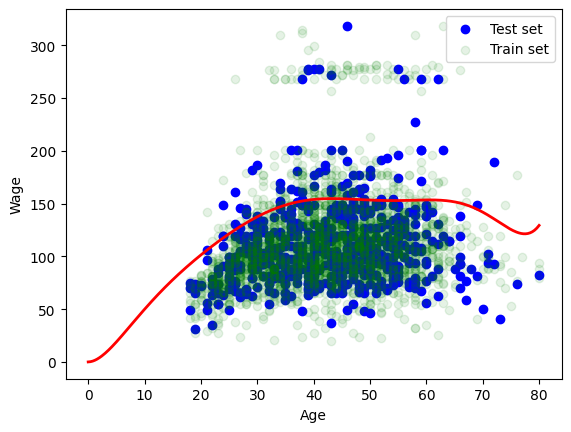

[ 5.34381844e-11 -1.62538785e-08  2.00943424e-06 -1.30397417e-04
  4.81005141e-03 -1.02513430e-01  1.14497236e+00  9.95239167e-02
  0.00000000e+00]


In [85]:
linear_model = pipeline.named_steps['regressor']
coefficients = linear_model.coef_.ravel()[::-1]

plot(coefficients)
print(coefficients)

### ANOVA


In [103]:
from scipy.stats import f

def calculate_rss(model, X, y):
    y_pred = model.predict(X)
    return np.sum((y - y_pred)**2, axis=0)






# We need the RSS for the d=1 (linear) model to start
poly_d_minus_1 = PolynomialFeatures(degree=1, include_bias=False)
X_d_minus_1 = poly_d_minus_1.fit_transform(x_train)
model_d_minus_1 = LinearRegression().fit(X_d_minus_1, y_train)
RSS_d_minus_1 = calculate_rss(model_d_minus_1, X_d_minus_1, y_train)


#Store data for DF
Degrees = []
F_stats = []
Pvalues = []

N_total = len(x_train)
max_degree = 10
for d in range(2, max_degree + 1):
    poly_d = PolynomialFeatures(degree=d, include_bias=False)
    X_d = poly_d.fit_transform(x_train)
    model_d = LinearRegression().fit(X_d, y_train)
    RSS_d = calculate_rss(model_d, X_d, y_train)

    df_d_minus_1 = N_total - d
    df_d = N_total - (d + 1)
    df_num = 1
    df_den = df_d

    # Calculate the F-statistic
    F_statistic = ((RSS_d_minus_1 - RSS_d) / df_num) / (RSS_d / df_den)

    # Calculate the p-value using Scipy's survival function (sf)
    p_value = f.sf(F_statistic, df_num, df_den)

    RSS_d_minus_1 = RSS_d

    Degrees.append(d)
    F_stats.append(float(F_statistic.iloc[0]))
    Pvalues.append(p_value[0])


result = pd.DataFrame({
    "Polynomial Degrees": Degrees,
    "F - statistic": F_stats,
    'p-value': Pvalues,
})

result

,Polynomial Degrees,F - statistic,p-value
0,2,113.027613,7.925148e-26
1,3,9.059357,2.640797e-03
2,4,2.189935,1.390467e-01
3,5,0.984277,3.212453e-01
4,6,1.195647,2.743035e-01
5,7,1.006361,3.158777e-01
6,8,-0.053771,1.000000e+00
7,9,-0.094327,1.000000e+00
8,10,0.006395,9.362707e-01


## Anova interpretation and model test

In [112]:
print(f"Best degree (ANOVA):\n{result.loc(result['p-value'].idxmin())[0]}")

pipeline.set_params(poly__degree=2)
pipeline.fit(x_train, y_train)

poly_score = metric(pipeline.predict(x_test), y_test)
poly_score

Best degree (ANOVA):
Polynomial Degrees    2.000000e+00
F - statistic         1.130276e+02
p-value               7.925148e-26
Name: 0, dtype: float64


,MSE,RMSE,R2
0,1445.075884,38.014154,0.073086


### Plot

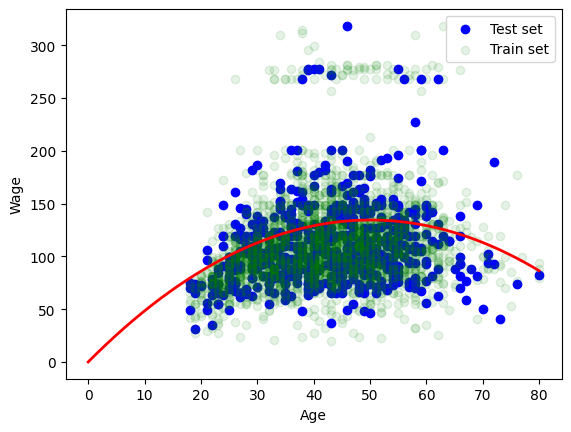

[-0.05363818  5.37103506  0.        ]


In [113]:
linear_model = pipeline.named_steps['regressor']
coefficients = linear_model.coef_.ravel()[::-1]

plot(coefficients)
print(coefficients)

# Step Function

In [186]:
def create_step_features(X, step, return_knots=False):
    X_features = []
    xmin = x_train.min().iloc[0]
    xmax = x_train.max().iloc[0]
    knots = np.arange(xmin,xmax , step=step)
    # print(f"{knots=}")

    # Segment 1: x < knot[0]
    X_features.append((X < knots[0]).astype(int))

    # Intermediate Segments
    for i in range(len(knots) - 1):
        feature = (X >= knots[i]) & (X < knots[i+1])
        X_features.append(feature.astype(int))

    # Last Segment: x >= knot[-1]
    X_features.append((X >= knots[-1]).astype(int))

    # Combine features into a single array
    if return_knots:
        knots = np.insert(knots, 0, 0)
        knots = np.append(knots, 100)
        return np.hstack(X_features), knots

    return np.hstack(X_features)

x_s = create_step_features(x_train, 10)
x_s

def objective_step(trial):
   step = trial.suggest_int('step', 2, 20)

   X_s = create_step_features(x_s, step)

   model = LinearRegression(fit_intercept=False)
   score = cross_val_score(model, X_s, y_train, cv=5, scoring='neg_mean_squared_error')

   return score.mean()


study = optuna.create_study(direction="maximize")
study.optimize(objective_step, n_trials=20, show_progress_bar=True)
print(f'{study.best_params=}')

X_step = create_step_features(x_train, study.best_params['step'])
model = LinearRegression(fit_intercept=False)

model.fit(X_step, y_train)
step_preds = model.predict(create_step_features(x_test, study.best_params['step']))

metric(step_preds, y_test)

[I 2025-12-08 14:42:32,563] A new study created in memory with name: no-name-9b386d41-4af5-4e99-a7fe-5655e126684a


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-12-08 14:42:32,640] Trial 0 finished with value: -1801.1406843143654 and parameters: {'step': 15}. Best is trial 0 with value: -1801.1406843143654.
[I 2025-12-08 14:42:32,723] Trial 1 finished with value: -1801.1406843143654 and parameters: {'step': 15}. Best is trial 0 with value: -1801.1406843143654.
[I 2025-12-08 14:42:32,802] Trial 2 finished with value: -1801.1406843143654 and parameters: {'step': 17}. Best is trial 0 with value: -1801.1406843143654.
[I 2025-12-08 14:42:32,896] Trial 3 finished with value: -1801.1728905298248 and parameters: {'step': 8}. Best is trial 0 with value: -1801.1406843143654.
[I 2025-12-08 14:42:32,998] Trial 4 finished with value: -1801.1728905298248 and parameters: {'step': 10}. Best is trial 0 with value: -1801.1406843143654.
[I 2025-12-08 14:42:33,306] Trial 5 finished with value: -1801.1317838333102 and parameters: {'step': 4}. Best is trial 5 with value: -1801.1317838333102.
[I 2025-12-08 14:42:33,428] Trial 6 finished with value: -1801.172

,MSE,RMSE,R2
0,1441.610176,37.968542,0.075309


# Plotting

[  0  18  22  26  30  34  38  42  46  50  54  58  62  66  70  74  78 100]
[ 87.30288261 101.3663308   97.5261247  121.00679828 114.43796857
 119.30598231 118.68114484 116.70530862 119.31977532 121.49515168
 119.87674914 111.87287467 105.84788356  97.36495125  79.4350875
  65.99275764   0.        ]


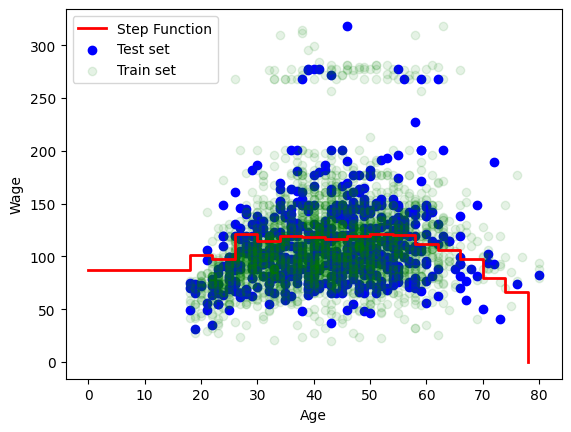

In [191]:
_ , knots = create_step_features(x_train, study.best_params['step'], return_knots=True)
coefficients = (model.coef_.ravel()[::-1])
print(knots)
print(coefficients)
plt.step(knots[:-1], coefficients, where='post', label='Step Function', color='red', linewidth=2)
plt.scatter(x_test, y_test, color='blue', label='Test set')
plt.scatter(x_train, y_train, color='green', label='Train set', alpha=0.1)
plt.xlabel('Age')
plt.ylabel('Wage')
plt.legend()
plt.show()